In [1]:
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"
period = 125

factor_file = "./data/CN_AFNS_Factor.csv"
feature_file ="./data/clean_features/all_features.csv"
result_file = "./data/ML_Pred_AFNS_Factor_6M.csv"


In [2]:
from pathlib import Path

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor
from pyearth.earth import Earth

In [3]:
import warnings


warnings.simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'


In [4]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index,
            columns = y.columns,
        )
        
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()
        
        self.model_2.fit(X_2, y_resid)
        
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()
        
        y_pred += self.model_2.predict(X_2)
        
        return y_pred

## 1.数据处理

In [5]:
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(start_date, end_date)

2012-01-01 00:00:00 2022-12-31 00:00:00


In [6]:
raw_y =  pd.read_csv(factor_file, index_col='Date', parse_dates=['Date'])
raw_X =  pd.read_csv(feature_file, index_col='Date', parse_dates=['Date'])

raw_X = raw_X[(raw_X.index>=start_date) & (raw_X.index<=end_date)]
raw_X




,CN_GDP_Current_Price_Cum_YTY,CN_GDP_Constant_Price_Cum_YTY,CN_GDP_Deflator_GDP_Cum_YTY,CN_GDP_Constant_Current_Q,CN_IFA_Cum_MTM,CN_IE_FGI_MTM,CN_PMI_New_Order,CN_PMI_RMP,CN_TRSCG_Cum_MOM,CN_PFE_MOM,...,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M,CN_New_Jobs_Cum,CN_Difficulty_Cum,CN_Reemployed_Cum
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.15000,0.20720,0.29530,0.4282,0.58250,0.81100,1.13035,1221.0,0.0,0.0
2012-01-05,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.14950,0.20620,0.29530,0.4292,0.58250,0.81200,1.13035,1221.0,0.0,0.0
2012-01-06,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.14900,0.20620,0.29630,0.4282,0.58150,0.81200,1.13035,1221.0,0.0,0.0
2012-01-09,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.14900,0.20620,0.29630,0.4282,0.58050,0.81000,1.12825,1221.0,0.0,0.0
2012-01-10,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.15000,0.20420,0.29580,0.4282,0.57950,0.80850,1.12605,1221.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,4.7989,...,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386,1145.0,163.0,476.0
2022-12-27,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,4.7989,...,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386,1145.0,163.0,476.0
2022-12-28,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,4.7989,...,4.31643,0.07638,4.38357,0.1525,4.72986,5.15114,5.47029,1145.0,163.0,476.0


In [7]:
# raw_X = raw_X[:500]
# raw_y = raw_y[:500]

In [8]:
print(raw_X.shape, raw_y.shape)

(2744, 182) (2744, 3)


In [9]:
# 由于是预测未来Period天的，所以需要将X进行移动
X = raw_X.shift(period).dropna()
X, y = X.align(raw_y, join="inner", axis=0)


In [10]:
print(X.shape, y.shape)

(2619, 182) (2619, 3)


## 2.Level建模

In [11]:
def get_beta_data(X, y, label):
    beta_y = y[[label]]

    trend_beta = beta_y.rolling(window = 20, center = True, min_periods = 5).mean()
    trend_beta.columns = ['trend']
    beta_X_1 = trend_beta

    beta_X_2 = X
    
    return beta_X_1, beta_X_2, beta_y
    

def get_beta_train_and_test_data(beta_X_1, beta_X_2, beta_y):
    
    # 训练集: 测试集 = 8：2
    data_ratio = 0.8
    N = beta_y.shape[0]
    length = int(data_ratio * N)

    beta_train_X_1 = beta_X_1[:length]
    beta_train_X_2 = beta_X_2[:length]
    beta_train_y = beta_y[:length]



    beta_test_X_1 = beta_X_1[length:]
    beta_test_X_2 = beta_X_2[length:]
    beta_test_y = beta_y[length:]
    return beta_train_X_1, beta_train_X_2, beta_train_y, beta_test_X_1, beta_test_X_2, beta_test_y


beta0_X_1, beta0_X_2, beta0_y = get_beta_data(X, y, "Level")

beta0_train_X_1, beta0_train_X_2, beta0_train_y, beta0_test_X_1, beta0_test_X_2, beta0_test_y = get_beta_train_and_test_data(beta0_X_1, beta0_X_2, beta0_y)


In [12]:
print(beta0_train_X_1.shape, beta0_train_X_2.shape, beta0_train_y.shape)

(2095, 1) (2095, 182) (2095, 1)


In [13]:
# 单步预测
def predict_beta(train_len, test_len, beta_X_1, beta_X_2, beta_y):
    all_len = train_len + test_len


    result_list = []
    for i in range(train_len, all_len, 1):
        print(i, all_len)
        use_beta_train_X_1 = beta_X_1[:i]
        use_beta_train_X_2 = beta_X_2[:i]
        use_beta_train_y = beta_y[:i]

        use_beta_test_X_1 = beta_X_1[i:i+1]
        use_beta_test_X_2 = beta_X_2[i:i+1]
        #temp_model = BoostedHybrid(model_1 = LinearRegression(), model_2 = XGBRegressor(),)
        temp_model = BoostedHybrid(model_1 = LinearRegression(), model_2 = XGBRegressor(),)
        temp_model.fit(use_beta_train_X_1, use_beta_train_X_2, use_beta_train_y)
        temp_value = temp_model.predict(use_beta_test_X_1, use_beta_test_X_2).mean()
        result_list.append(temp_value)
    
    return result_list


train_len = beta0_train_y.shape[0]
test_len = beta0_test_y.shape[0]
beta0_predict_list = predict_beta(train_len, test_len, beta0_X_1, beta0_X_2, beta0_y)
beta0_predict_list

2095 2619
2096 2619
2097 2619
2098 2619
2099 2619
2100 2619
2101 2619
2102 2619
2103 2619
2104 2619
2105 2619
2106 2619
2107 2619
2108 2619
2109 2619
2110 2619
2111 2619
2112 2619
2113 2619
2114 2619
2115 2619
2116 2619
2117 2619
2118 2619
2119 2619
2120 2619
2121 2619
2122 2619
2123 2619
2124 2619
2125 2619
2126 2619
2127 2619
2128 2619
2129 2619
2130 2619
2131 2619
2132 2619
2133 2619
2134 2619
2135 2619
2136 2619
2137 2619
2138 2619
2139 2619
2140 2619
2141 2619
2142 2619
2143 2619
2144 2619
2145 2619
2146 2619
2147 2619
2148 2619
2149 2619
2150 2619
2151 2619
2152 2619
2153 2619
2154 2619
2155 2619
2156 2619
2157 2619
2158 2619
2159 2619
2160 2619
2161 2619
2162 2619
2163 2619
2164 2619
2165 2619
2166 2619
2167 2619
2168 2619
2169 2619
2170 2619
2171 2619
2172 2619
2173 2619
2174 2619
2175 2619
2176 2619
2177 2619
2178 2619
2179 2619
2180 2619
2181 2619
2182 2619
2183 2619
2184 2619
2185 2619
2186 2619
2187 2619
2188 2619
2189 2619
2190 2619
2191 2619
2192 2619
2193 2619
2194 2619


[7.664935,
 7.6665993,
 7.6714344,
 7.6772556,
 7.680528,
 7.68435,
 7.685342,
 7.685741,
 7.6887116,
 7.686319,
 7.6836452,
 7.6893644,
 7.6863794,
 7.6837163,
 7.685446,
 7.680634,
 7.680652,
 7.6793957,
 7.6704197,
 7.6702843,
 7.670356,
 7.6672754,
 7.6592107,
 7.6575522,
 7.653657,
 7.646326,
 7.638904,
 7.6344504,
 7.6290774,
 7.6214895,
 7.620864,
 7.614259,
 7.6067457,
 7.6006722,
 7.5944076,
 7.583004,
 7.5841794,
 7.57115,
 7.5692415,
 7.5660954,
 7.563318,
 7.558709,
 7.55362,
 7.5445695,
 7.545003,
 7.536147,
 7.5401964,
 7.534441,
 7.532528,
 7.529243,
 7.527812,
 7.525396,
 7.5294676,
 7.5257483,
 7.520326,
 7.516836,
 7.515228,
 7.5098,
 7.510917,
 7.5090322,
 7.5042253,
 7.5055127,
 7.501152,
 7.498193,
 7.496249,
 7.494148,
 7.490819,
 7.486787,
 7.484277,
 7.480973,
 7.478342,
 7.4732623,
 7.469014,
 7.468279,
 7.4735355,
 7.4688325,
 7.4624047,
 7.4646406,
 7.4624887,
 7.461061,
 7.457954,
 7.457035,
 7.4518285,
 7.447898,
 7.447541,
 7.446031,
 7.4459896,
 7.4440174

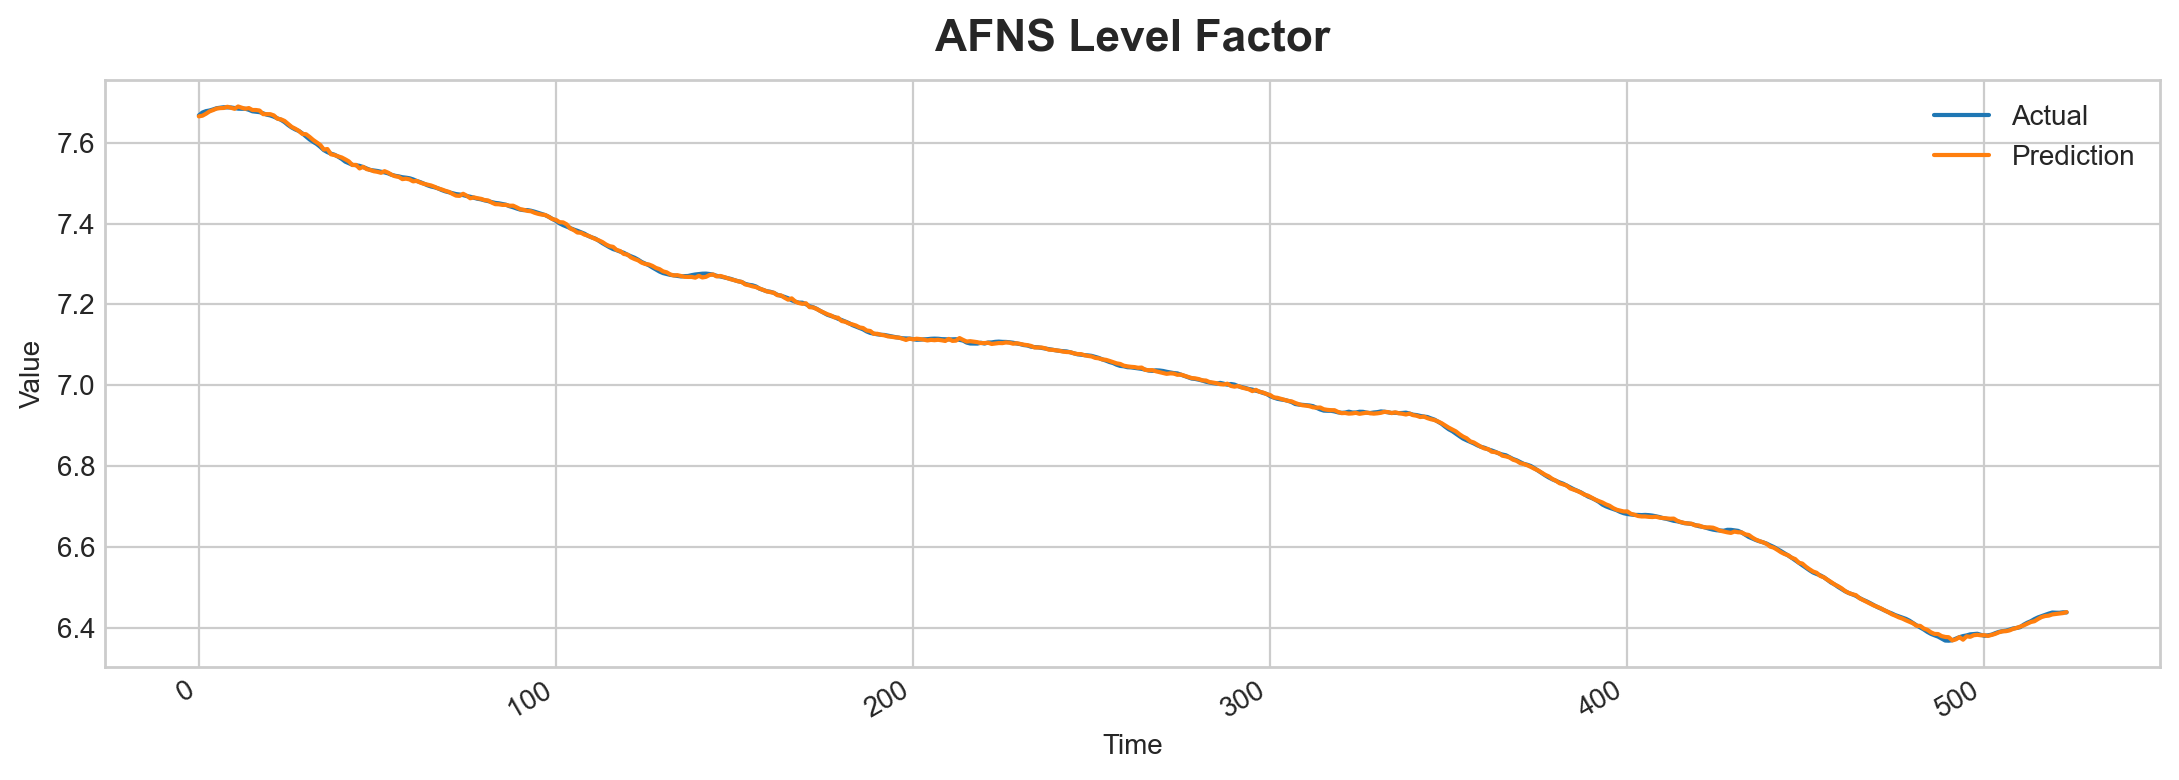

In [26]:
def plot_predict(atual_value, predict_value, label="Beta0"):
    fig, ax = plt.subplots()

    ax.plot(atual_value, label="Actual")
    ax.plot(predict_value, label="Prediction")
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

    plt.title(f"AFNS {label} Factor")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.legend()
    
plot_predict(beta0_test_y.values, beta0_predict_list, label="Level")

## 3.Slope建模

In [15]:
beta1_X_1, beta1_X_2, beta1_y = get_beta_data(X, y, "Slope")

beta1_train_X_1, beta1_train_X_2, beta1_train_y, \
    beta1_test_X_1, beta1_test_X_2, beta1_test_y = get_beta_train_and_test_data(beta1_X_1, beta1_X_2, beta1_y)


In [16]:
print(beta1_train_X_1.shape, beta1_train_X_2.shape, beta1_train_y.shape)

(2095, 1) (2095, 182) (2095, 1)


In [17]:
train_len = beta1_train_y.shape[0]
test_len = beta1_test_y.shape[0]
beta1_predict_list = predict_beta(train_len, test_len, beta1_X_1, beta1_X_2, beta1_y)
beta1_predict_list

2095 2619
2096 2619
2097 2619
2098 2619
2099 2619
2100 2619
2101 2619
2102 2619
2103 2619
2104 2619
2105 2619
2106 2619
2107 2619
2108 2619
2109 2619
2110 2619
2111 2619
2112 2619
2113 2619
2114 2619
2115 2619
2116 2619
2117 2619
2118 2619
2119 2619
2120 2619
2121 2619
2122 2619
2123 2619
2124 2619
2125 2619
2126 2619
2127 2619
2128 2619
2129 2619
2130 2619
2131 2619
2132 2619
2133 2619
2134 2619
2135 2619
2136 2619
2137 2619
2138 2619
2139 2619
2140 2619
2141 2619
2142 2619
2143 2619
2144 2619
2145 2619
2146 2619
2147 2619
2148 2619
2149 2619
2150 2619
2151 2619
2152 2619
2153 2619
2154 2619
2155 2619
2156 2619
2157 2619
2158 2619
2159 2619
2160 2619
2161 2619
2162 2619
2163 2619
2164 2619
2165 2619
2166 2619
2167 2619
2168 2619
2169 2619
2170 2619
2171 2619
2172 2619
2173 2619
2174 2619
2175 2619
2176 2619
2177 2619
2178 2619
2179 2619
2180 2619
2181 2619
2182 2619
2183 2619
2184 2619
2185 2619
2186 2619
2187 2619
2188 2619
2189 2619
2190 2619
2191 2619
2192 2619
2193 2619
2194 2619


[-4.948037,
 -4.9556823,
 -4.9402566,
 -4.99329,
 -4.9710364,
 -4.9600163,
 -4.9902935,
 -5.016121,
 -5.0231476,
 -4.999469,
 -5.0369477,
 -5.0641303,
 -5.0511765,
 -5.0664186,
 -5.1081753,
 -5.118274,
 -5.111584,
 -5.1880193,
 -5.170793,
 -5.196699,
 -5.2064447,
 -5.1970897,
 -5.235985,
 -5.2423096,
 -5.256521,
 -5.282795,
 -5.250642,
 -5.258263,
 -5.240553,
 -5.2518244,
 -5.2971835,
 -5.3188195,
 -5.304734,
 -5.3368816,
 -5.315483,
 -5.298683,
 -5.2852993,
 -5.249484,
 -5.242971,
 -5.260772,
 -5.257064,
 -5.257772,
 -5.2017107,
 -5.183477,
 -5.1542025,
 -5.1360908,
 -5.1579,
 -5.1278524,
 -5.0672655,
 -5.0960927,
 -5.0465355,
 -5.085366,
 -5.0483627,
 -5.0674186,
 -5.0496273,
 -5.0534153,
 -5.043076,
 -5.045544,
 -5.047975,
 -5.069679,
 -5.0602655,
 -5.0966883,
 -5.0498276,
 -5.076677,
 -5.0459332,
 -5.0676193,
 -5.036674,
 -5.087274,
 -5.0568314,
 -5.0388002,
 -5.0279074,
 -5.0102167,
 -5.0343986,
 -4.995343,
 -5.00155,
 -5.0018992,
 -4.9955263,
 -5.002527,
 -5.0082364,
 -5.0409703,

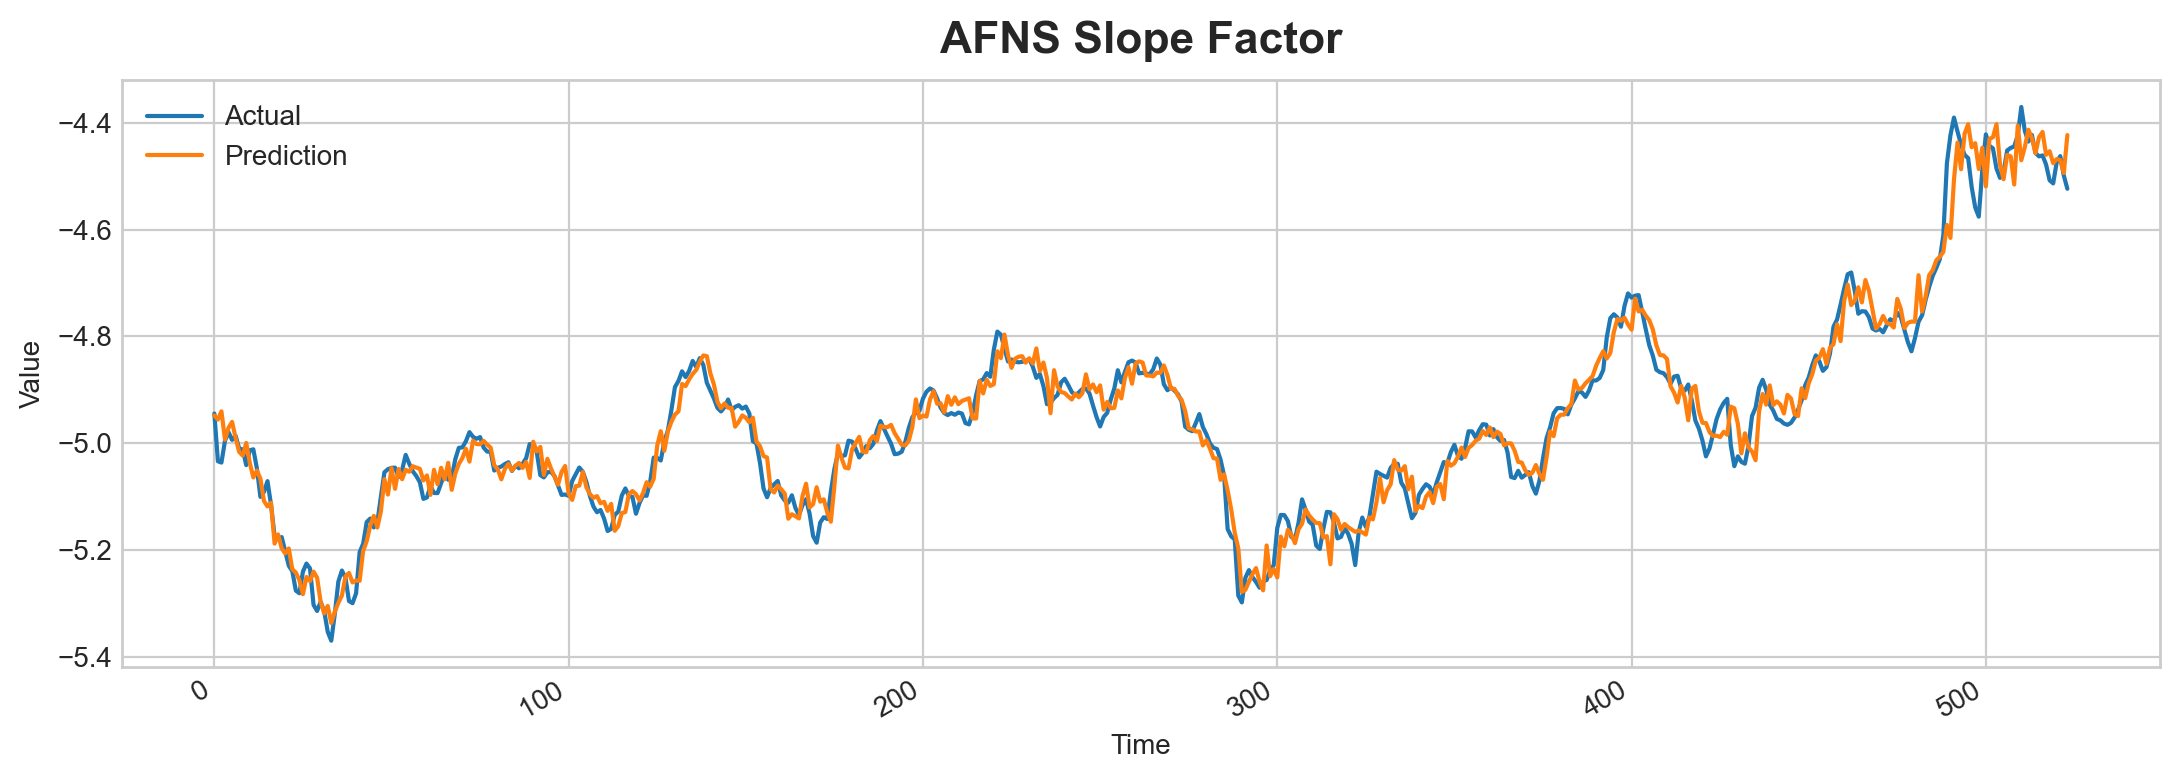

In [27]:
plot_predict(beta1_test_y.values, beta1_predict_list, label="Slope")

In [19]:
print(len(beta1_test_y.values), len(beta1_predict_list))

524 524


## Curvature 预测


In [20]:
beta2_X_1, beta2_X_2, beta2_y = get_beta_data(X, y, "Curvature")

beta2_train_X_1, beta2_train_X_2, beta2_train_y, \
    beta2_test_X_1, beta2_test_X_2, beta2_test_y = get_beta_train_and_test_data(beta2_X_1, beta2_X_2, beta2_y)

In [21]:
print(beta2_train_X_1.shape, beta2_train_X_2.shape, beta2_train_y.shape)

(2095, 1) (2095, 182) (2095, 1)


In [22]:
train_len = beta2_train_y.shape[0]
test_len = beta2_test_y.shape[0]
beta2_predict_list = predict_beta(train_len, test_len, beta2_X_1, beta2_X_2, beta2_y)
beta2_predict_list

2095 2619
2096 2619
2097 2619
2098 2619
2099 2619
2100 2619
2101 2619
2102 2619
2103 2619
2104 2619
2105 2619
2106 2619
2107 2619
2108 2619
2109 2619
2110 2619
2111 2619
2112 2619
2113 2619
2114 2619
2115 2619
2116 2619
2117 2619
2118 2619
2119 2619
2120 2619
2121 2619
2122 2619
2123 2619
2124 2619
2125 2619
2126 2619
2127 2619
2128 2619
2129 2619
2130 2619
2131 2619
2132 2619
2133 2619
2134 2619
2135 2619
2136 2619
2137 2619
2138 2619
2139 2619
2140 2619
2141 2619
2142 2619
2143 2619
2144 2619
2145 2619
2146 2619
2147 2619
2148 2619
2149 2619
2150 2619
2151 2619
2152 2619
2153 2619
2154 2619
2155 2619
2156 2619
2157 2619
2158 2619
2159 2619
2160 2619
2161 2619
2162 2619
2163 2619
2164 2619
2165 2619
2166 2619
2167 2619
2168 2619
2169 2619
2170 2619
2171 2619
2172 2619
2173 2619
2174 2619
2175 2619
2176 2619
2177 2619
2178 2619
2179 2619
2180 2619
2181 2619
2182 2619
2183 2619
2184 2619
2185 2619
2186 2619
2187 2619
2188 2619
2189 2619
2190 2619
2191 2619
2192 2619
2193 2619
2194 2619


[-2.7074704,
 -2.7277243,
 -2.7057388,
 -2.7453754,
 -2.685454,
 -2.734195,
 -2.7578661,
 -2.7369707,
 -2.7231538,
 -2.764741,
 -2.734939,
 -2.7360685,
 -2.72966,
 -2.7258263,
 -2.6898758,
 -2.6537886,
 -2.6130412,
 -2.5730357,
 -2.5486622,
 -2.5510864,
 -2.53308,
 -2.508731,
 -2.5500069,
 -2.499392,
 -2.5083933,
 -2.491297,
 -2.4898696,
 -2.4544919,
 -2.4192553,
 -2.421708,
 -2.3944168,
 -2.37245,
 -2.381651,
 -2.2844055,
 -2.2733507,
 -2.267361,
 -2.2686691,
 -2.231403,
 -2.2552605,
 -2.2285786,
 -2.197305,
 -2.2185419,
 -2.2469988,
 -2.236035,
 -2.2654893,
 -2.2930863,
 -2.2733996,
 -2.2798207,
 -2.287508,
 -2.2875688,
 -2.2582643,
 -2.2854276,
 -2.2367063,
 -2.257131,
 -2.251103,
 -2.247238,
 -2.2315538,
 -2.1953468,
 -2.1750374,
 -2.1607852,
 -2.1241052,
 -2.0833912,
 -2.0642507,
 -2.0514874,
 -2.0375469,
 -2.0567956,
 -2.0936172,
 -2.0596533,
 -2.0426435,
 -2.0470986,
 -2.0564725,
 -2.0798523,
 -2.094496,
 -2.0751948,
 -2.0790834,
 -2.0982478,
 -2.1192029,
 -2.1300795,
 -2.104580

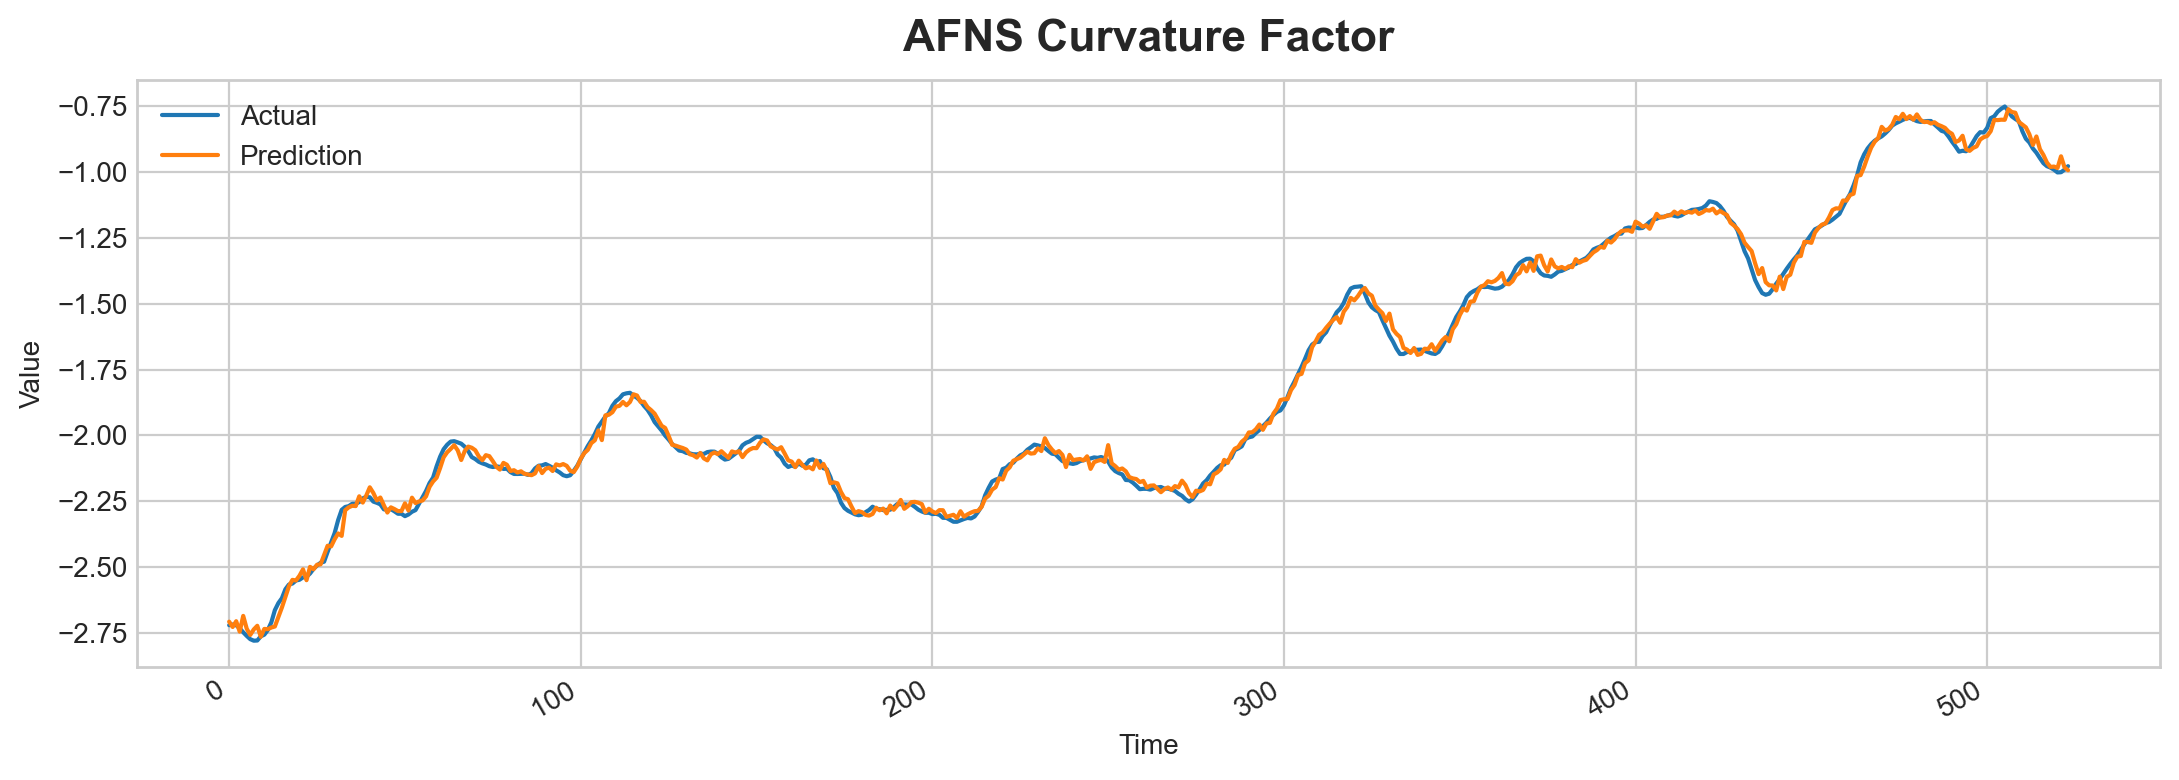

In [28]:
plot_predict(beta2_test_y.values, beta2_predict_list, label="Curvature")

## 合并数据

In [24]:
# data
result_df = pd.DataFrame()
result_y = y[train_len:]
result_df['Date'] = result_y.index
result_df['Level'] = beta0_predict_list
result_df['Slope'] = beta1_predict_list
result_df['Curvature'] = beta2_predict_list
result_df

,Date,Level,Slope,Curvature
0,2020-11-27,7.664935,-4.948037,-2.707470
1,2020-11-30,7.666599,-4.955682,-2.727724
2,2020-12-01,7.671434,-4.940257,-2.705739
3,2020-12-02,7.677256,-4.993290,-2.745375
4,2020-12-03,7.680528,-4.971036,-2.685454
...,...,...,...,...
519,2022-12-26,6.433586,-4.475542,-0.979336
520,2022-12-27,6.434600,-4.467660,-0.984793
521,2022-12-28,6.435513,-4.469728,-0.940376
522,2022-12-29,6.436872,-4.493849,-0.982379


In [25]:
result_df.to_csv(result_file, index=False, encoding="utf-8-sig")